# Long-Short Strategy, Part 6: Backtesting with Zipline

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb) : we predict returns for our out-of-sample period 2017.
6. `backtesting_with_zipline` (this noteboook): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [292]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap


In [293]:
N_LONGS = 5

## Load Data

### ML Predictions

In [294]:
DATA_STORE = './data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = store['merval/prices'].sort_index()['close'].loc[pd.IndexSlice['2020':'2024']]
prices.index.names = ['date', 'symbol']
prices

date        symbol  
2020-01-02  ALUA.BA        32.000000
            AUSO.BA        75.599998
            BBAR.BA       139.000000
            BHIP.BA        14.100000
            BMA.BA        162.301086
                            ...     
2023-12-29  TGSU2.BA     2956.149902
            TRAN.BA      1210.000000
            TXAR.BA       849.000000
            VALO.BA       225.250000
            YPFD.BA     16688.199219
Name: close, Length: 56375, dtype: float64

In [295]:
predictions = pd.concat([pd.read_hdf('data/predictions.h5', 'lgb/train/01'), pd.read_hdf('data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)])
predictions = (predictions.loc[~predictions.index.duplicated()]
				.iloc[:, :10]
				.mean(1)
				.sort_index()
				.dropna()
				.to_frame('prediction'))
tickers = predictions.index.get_level_values('symbol').unique().tolist()

In [296]:
predictions = predictions.join(prices)

In [297]:
predictions

prediction         close
symbol  date                                
ALUA.BA 2020-12-03    0.009860     52.200001
        2020-12-04    0.014928     52.200001
        2020-12-09    0.008148     48.950001
        2020-12-10    0.018542     50.099998
        2020-12-11    0.027393     49.450001
...                        ...           ...
YPFD.BA 2023-12-21    0.008689  17129.900391
        2023-12-22   -0.000476  16866.599609
        2023-12-26   -0.004595  16425.150391
        2023-12-27    0.002812  15696.849609
        2023-12-28    0.018609  15968.500000

[32077 rows x 2 columns]

## Backtesting

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions

def backtest(df, initial_capital=1):
	portfolio_value = []
	positions = dict()
	value = initial_capital

	dates = df.index.levels[1]
	for date in dates:
		daily_df = df.xs(date, level='date')

		# use open positions to compute total value
		if len(positions) > 0:
			value = 0
			for (ticker, alloc) in positions.items():
				price = daily_df.loc[ticker, 'close']
				value += price * alloc
		portfolio_value.append(value)

		# select next 5 best predictions
		top_predictions = daily_df.nlargest(N_LONGS, 'prediction')

		# update open positions
		positions = dict()
		allocation = value / len(top_predictions)
		for ticker in top_predictions.index:
			price = daily_df.loc[ticker, 'close']
			positions[ticker] = allocation / price

	return portfolio_value

portfolio_value = backtest(df)

portfolio_df = pd.DataFrame({
    'date': df.index.levels[1],
    'portfolio_value': portfolio_value
})

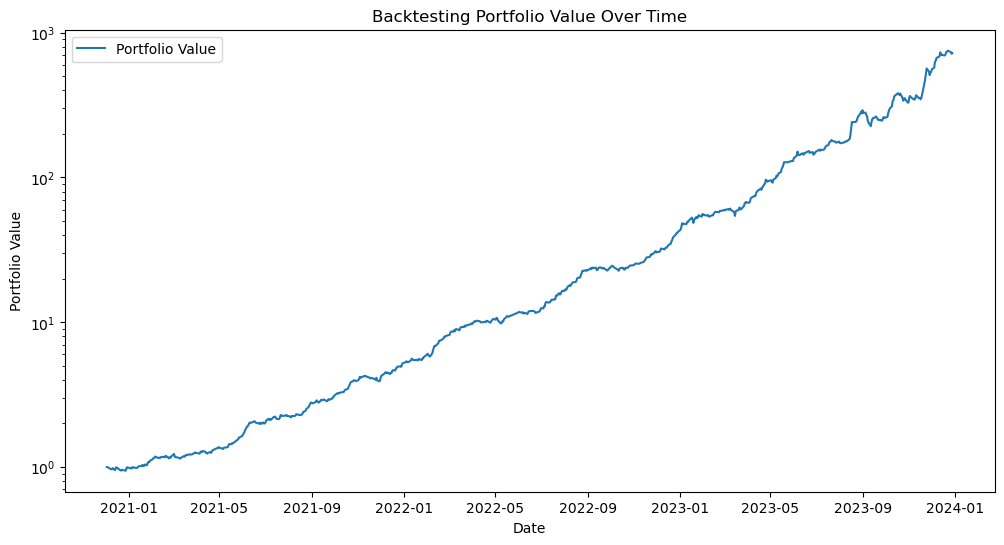

In [299]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.yscale('log')
plt.title('Backtesting Portfolio Value Over Time')
plt.legend()
plt.show()


In [300]:
sp_merval = pd.read_csv('./data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'close'}).set_index(['date'])['close']

In [301]:
sp_merval.reindex(portfolio_df.set_index('date').index)

date
2020-12-03   NaN
2020-12-04   NaN
2020-12-09   NaN
2020-12-10   NaN
2020-12-11   NaN
              ..
2023-12-21   NaN
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
Name: close, Length: 746, dtype: float64

In [302]:
DATA_STORE = './data/assets.h5'
ohlcv = ['open', 'close', 'low', 'high', 'volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices'][ohlcv])

# CARGAR SPMERVAL

## Indice 

In [303]:
import requests
from bs4 import BeautifulSoup

# get all components of merval index
url = "https://es.wikipedia.org/wiki/S%26P_Merval"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

panel_lider_section = soup.find(id="Empresas_que_participan_Panel_Líder")
lider_table = panel_lider_section.find_next("table")

panel_lider = []
for row in lider_table.find_all('tr')[1:]:  # Skip the header row
    cols = row.find_all('td')
    ticker = cols[0].text.strip()
    panel_lider.append(ticker + ".BA")
len(panel_lider)

21

In [304]:
index = predictions.index.levels[0].intersection(panel_lider)


In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions

def backtest(df, initial_capital=1):
	portfolio_value = []
	positions = dict()
	value = initial_capital

	dates = df.index.levels[1]
	for date in dates:
		daily_df = df.xs(date, level='date')

		# use open positions to compute total value
		if len(positions) > 0:
			value = 0
			for (ticker, alloc) in positions.items():
				price = daily_df.loc[ticker, 'close']
				value += price * alloc
		portfolio_value.append(value)

		# update open positions
		positions = dict()
		allocation = value / len(index)
		for ticker in index:
			price = daily_df.loc[ticker, 'close']
			positions[ticker] = allocation / price

	return portfolio_value

index_value = backtest(df)

index_df = pd.DataFrame({
    'date': df.index.levels[1],
    'MERVAL': index_value
})

In [306]:
index_df

,date,MERVAL
0,2020-12-03,1.000000
1,2020-12-04,0.989274
2,2020-12-09,0.951113
3,2020-12-10,0.969626
4,2020-12-11,0.972872
...,...,...
741,2023-12-21,17.657864
742,2023-12-22,17.782588
743,2023-12-26,17.212227
744,2023-12-27,16.525203


## PyFolio Analysis

To visualize the out-of-sample performance, we pass '2022-01-01' as start date for the `live_start_date`:

In [307]:
returns = portfolio_df.set_index('date')['portfolio_value'].pct_change().tz_localize('UTC')

In [308]:
# sp_merval = pd.read_csv('./data/merval.csv')
# sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'MERVAL'})
# sp_merval['date'] = pd.to_datetime(sp_merval['date'])

sp_merval = index_df

In [309]:
benchmark = sp_merval.set_index(['date'])['MERVAL'].pct_change().tz_localize('UTC')
benchmark = benchmark.reindex(returns.index)

In [310]:
benchmark

date
2020-12-03 00:00:00+00:00         NaN
2020-12-04 00:00:00+00:00   -0.010726
2020-12-09 00:00:00+00:00   -0.038575
2020-12-10 00:00:00+00:00    0.019464
2020-12-11 00:00:00+00:00    0.003348
                               ...   
2023-12-21 00:00:00+00:00    0.020304
2023-12-22 00:00:00+00:00    0.007063
2023-12-26 00:00:00+00:00   -0.032074
2023-12-27 00:00:00+00:00   -0.039915
2023-12-28 00:00:00+00:00    0.031216
Name: MERVAL, Length: 746, dtype: float64

In [311]:
returns

date
2020-12-03 00:00:00+00:00         NaN
2020-12-04 00:00:00+00:00   -0.002326
2020-12-09 00:00:00+00:00   -0.033723
2020-12-10 00:00:00+00:00    0.010446
2020-12-11 00:00:00+00:00    0.007713
                               ...   
2023-12-21 00:00:00+00:00    0.004707
2023-12-22 00:00:00+00:00    0.015574
2023-12-26 00:00:00+00:00   -0.020144
2023-12-27 00:00:00+00:00   -0.027044
2023-12-28 00:00:00+00:00    0.008092
Name: portfolio_value, Length: 746, dtype: float64

### Custom Plots

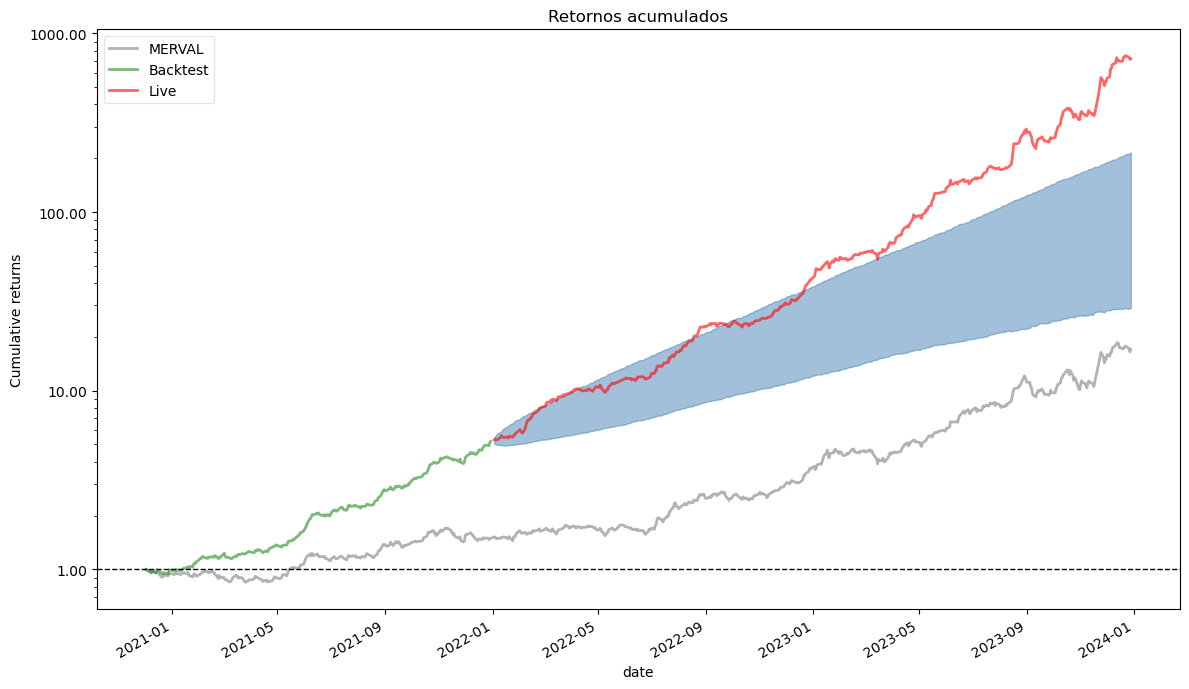

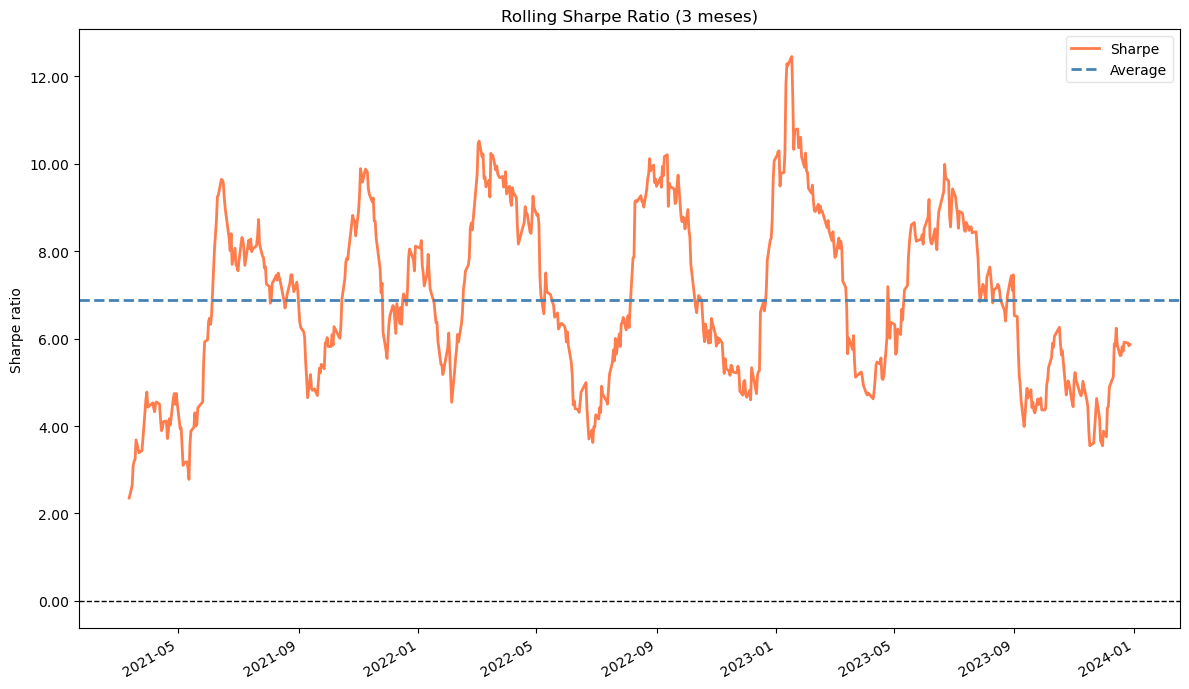

In [312]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
plot_rolling_returns(
    returns,
    factor_returns=benchmark,
    live_start_date='2022-01-01',
    logy=True,
    cone_std=2,
    legend_loc='best',
    volatility_match=False,
    cone_function=forecast_cone_bootstrap,
    ax=ax1
)
ax1.set_title('Retornos acumulados')
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(12, 7))
plot_rolling_sharpe(returns, ax=ax2, rolling_window=63)
ax2.set_title('Rolling Sharpe Ratio (3 meses)')
fig2.tight_layout()

plt.show()


Compute anualized variation of merval:

In [313]:
from math import sqrt
first_row = sp_merval.iloc[0]
last_row = sp_merval.iloc[-1]
increase = (last_row['MERVAL'] / first_row['MERVAL'])
print(f'The MERVAL index grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The MERVAL index grew by x17.041062
Anualized is: %257.335015


In [314]:
from math import sqrt
first_row = portfolio_df.iloc[0]
last_row = portfolio_df.iloc[-1]
increase = (last_row['portfolio_value'] / first_row['portfolio_value'])
print(f'The PORTFOLIO grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The PORTFOLIO grew by x721.260009
Anualized is: %896.803479


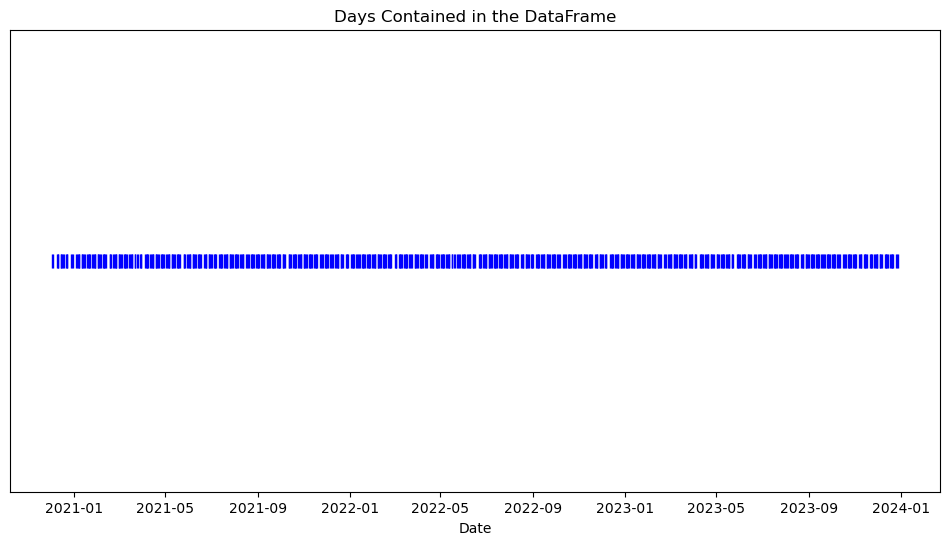

In [315]:
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplo de creación de DataFrame
dates = portfolio_df['date']
portfolio_values = portfolio_df['portfolio_value']
df = pd.DataFrame({'portfolio_value': portfolio_values}, index=dates)

# Crear una serie de datos indicando los días contenidos en el DataFrame
days_in_df = df.index

# Graficar los días contenidos en el DataFrame
plt.figure(figsize=(12, 6))
plt.plot(days_in_df, [1]*len(days_in_df), '|', color='blue', markersize=10)  # Use pipe marker to indicate dates
plt.xlabel('Date')
plt.title('Days Contained in the DataFrame')
plt.yticks([])  # Remove y-axis ticks since we only care about the dates
plt.show()


### Tear Sheets

/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.40,2023-08-31,2023-09-11,2023-10-06,27
1,13.92,2023-10-17,2023-10-30,2023-11-21,26
2,10.87,2023-03-09,2023-03-15,2023-03-21,9
3,10.08,2023-11-24,2023-11-28,2023-12-04,7
4,8.69,2022-05-03,2022-05-09,2022-05-16,10


IndexError: index -1 is out of bounds for axis 0 with size 0

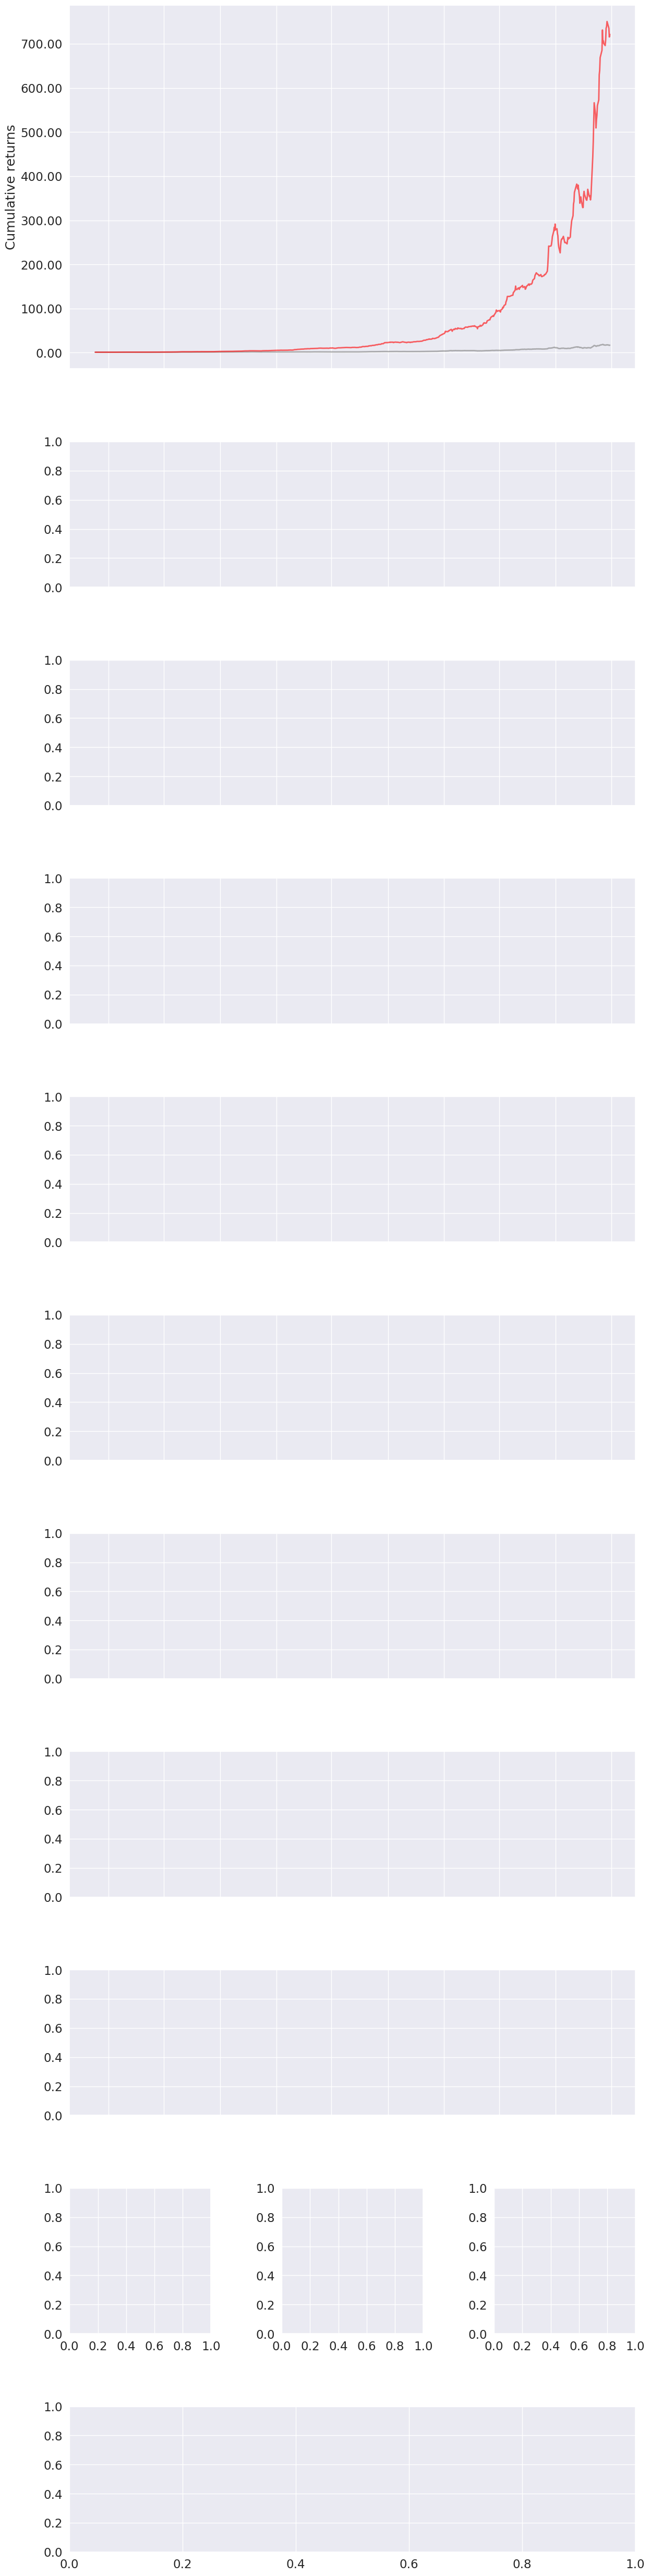

In [316]:
pf.create_full_tear_sheet(returns, 
                          positions=None, 
                          transactions=None,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)